In [16]:
import os
import glob
import time
import pickle
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import imageio

from collections import deque
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip
from imgaug import augmenters as iaa

In [17]:
TEST_SIZE = 0.1
SAMPLE_DISPLAY = 5
SVC_ITER = 10000
SVC_C = 0.001
CV_ITERS = 4
READ_PICKLE = False

FTR_HOG = True
FTR_BIN_SPTL = True
FTR_CLR_HIST = True

COLORSPACE = 'YCrCb'
ORIENT = 9
PIXEL_PER_CELL = 8
CELL_PER_BLOCK = 2
HOG_CHNL = 'ALL'
SPATIAL_SIZE = (32,32)
HISTO_BINS = 32
BINS_RANGE = (0, 256)

SEQ_RTT = iaa.Affine(rotate=(-20, 20)) # rotate by -20 to +20 degrees
SEQ_FLIP = iaa.Fliplr(1.0) # always horizontally flip each input image
SEQ_BLR = iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
SEQ_SHRP = iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)) # sharpen images
SEQ_BRT = iaa.Add((-10, 10), per_channel=0.5) # change brightness of images (by -10 to 10 of original value)

In [18]:
VEHICLE_IMG_PATHS = 'C:\\Users\\Yiqun\Downloads\\training_images\\vehicles\\*\\*.png'
NON_VEHICLE_IMG_PATHS = 'C:\\Users\\Yiqun\Downloads\\training_images\\non-vehicles\\*\\*.png'

In [19]:
def extract_hog_features(img, orient, pix_per_cell, cell_per_block, vis = False, feature_vec = True):
    #if call with two outputs then vis = True
    if vis == True:
        features, hog_image = hog(
            img,
            orientations = orient,
            pixels_per_cell = (pix_per_cell, pix_per_cell),
            cells_per_block = (cell_per_block, cell_per_block),
            block_norm = 'L2-Hys',
            transform_sqrt = True,
            visualize = vis,
            feature_vector = feature_vec
        )
        return features, hog_image
    else:
        features = hog(
            img,
            orientations = orient,
            pixels_per_cell = (pix_per_cell, pix_per_cell),
            cells_per_block = (cell_per_block, cell_per_block),
            block_norm = 'L2-Hys',
            transform_sqrt = True,
            visualize = vis,
            feature_vector = feature_vec            
        )
        return features

def extract_bin_spatial(
    image,
    spatial_size = (32, 32)
):
    features = cv2.resize(image, spatial_size).ravel()
    return features

def extract_color_hist(
    image,
    hist_bins=32,
    bins_range=(0,256)
):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(image[:,:,0], bins = hist_bins, range = bins_range)
    channel2_hist = np.histogram(image[:,:,1], bins = hist_bins, range = bins_range)
    channel3_hist = np.histogram(image[:,:,2], bins = hist_bins, range = bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def convert_img_cspace(image, cspace = 'RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(image)
    return feature_image

def extract_features(
    img,
    hog = True,
    bin_spatial = True,
    color_histo = True,
    orient = 9,
    pix_per_cell = 8,
    cell_per_block = 2,
    hog_channel = 0,
    hist_bins = 32,
    bins_range = (0, 256),
    spatial_size = (32, 32)
):
    # define an empty list to receive features
    img_features = []

    # compute spatial features if the flag is set:
    if bin_spatial == True:
        spatial_features = extract_bin_spatial(img, spatial_size= spatial_size)
        img_features.append(spatial_features)
    
    # compute color histogram features if flag is set:
    if color_histo == True:
        hist_features = extract_color_hist(
            img, hist_bins = hist_bins, bins_range = bins_range
        )
        img_features.append(hist_features)

    # compute HOG features if flag is set:
    if hog == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(img.shape[2]):
                hog_features.extend(
                    extract_hog_features(
                        img[:,:,channel], orient, pix_per_cell, cell_per_block)
                )
        else:
            hog_features = extract_hog_features(
                        img[:,:,hog_channel], orient, pix_per_cell, cell_per_block)

        #append the new feature vector to the features list:
        img_features.append(hog_features)
    
    return np.concatenate(img_features)

def extract_all_features(
    img_paths,
    cspace = 'RGB',
    hog = True,
    bin_spatial = True,
    color_histo = True,
    orient = 9,
    pix_per_cell = 8,
    cell_per_block = 2,
    hog_channel = 0,
    hist_bins = 32,
    bins_range = (0,255),
    spatial_size = (32, 32)
):
    # Create a list to append feature vectors
    features = []
    # Iterate through the list of the images:
    for file in img_paths:
        # Read in each one:
        image = mpimg.imread(file)

        all_images = [
            image,
#              SEQ_RTT.augment_image(image), 
#             SEQ_FLIP.augment_image(image), 
#              SEQ_BLR.augment_image(image), 
#             SEQ_SHRP.augment_image(image),
#             SEQ_BRT.augment_image(image)            
        ]

        for image in all_images:
            converted = convert_img_cspace(img, cspace)
            feature = extract_features(
                converted,
                hog=hog,
                bin_spatial=bin_spatial,
                color_histo=color_histo,
                orient=orient,
                pix_per_cell=pix_per_cell,
                cell_per_block=cell_per_block, 
                hog_channel=hog_channel,
                hist_bins=hist_bins,
                bins_range=bins_range,
                spatial_size=spatial_size,
            )
            features.append(feature)
    return features

def convert_to_std(img_paths, size):
    for loc in img_paths:
        image = mpimg.imread(loc)
    
    y = image.shape[0]
    x = image.shape[1]

    if y < x:
        crop_img = image[:y, 0:x]
    elif y > x:
        crop_img = image[0:x, :x]
    else:
        crop_img = image
    
    resized = cv2.resize(crop_img, size)
    mpimg.imsave(loc, resized)

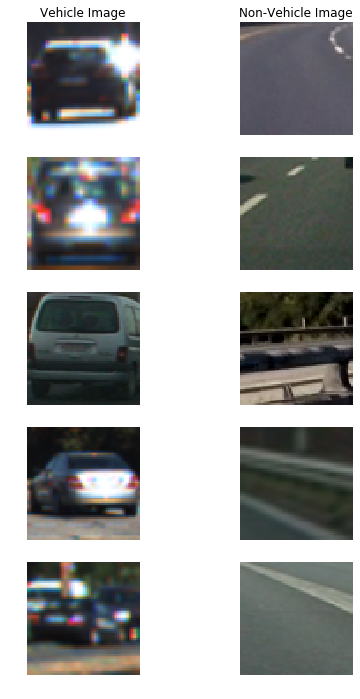

In [20]:
vehicle_img_locs = glob.glob(VEHICLE_IMG_PATHS)
non_vehicle_img_locs = glob.glob(NON_VEHICLE_IMG_PATHS)

#convert_to_std(vehicle_img_locs, (64, 64))
#convert_to_std(non_vehicle_img_locs, (64, 64))

# Set up figure for plotting
f, axarr = plt.subplots(SAMPLE_DISPLAY, 2)
f.set_size_inches(7,12)

for i in range(SAMPLE_DISPLAY):
    if i == 0:
        axarr[i, 0].set_title("Vehicle Image")
        axarr[i, 1].set_title("Non-Vehicle Image")
    # plot now
    rand_vehicle_img = vehicle_img_locs[random.randrange(len(vehicle_img_locs))]
    rand_non_vehicle_img = non_vehicle_img_locs[random.randrange(len(non_vehicle_img_locs))]
    axarr[i, 0].imshow(mpimg.imread(rand_vehicle_img))
    axarr[i, 0].axis('off')
    axarr[i, 1].imshow(mpimg.imread(rand_non_vehicle_img))
    axarr[i, 1].axis('off')

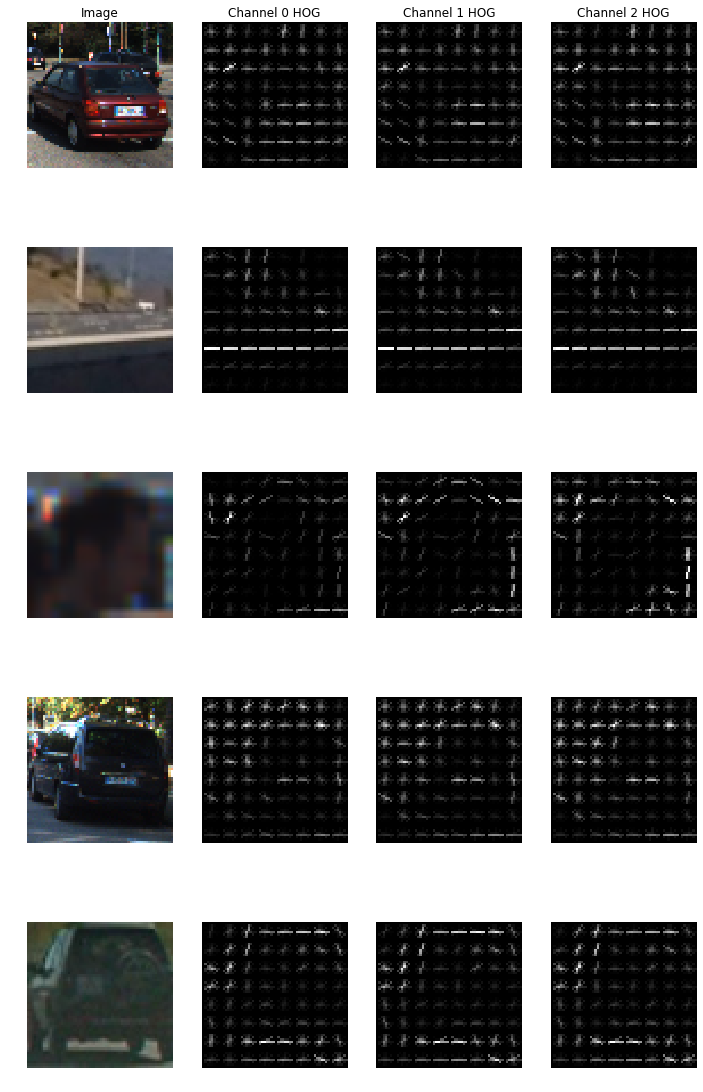

In [21]:
#set up hog figure for plotting
f, axarr = plt.subplots(SAMPLE_DISPLAY, 4)
f.set_size_inches(12, 20)

for i in range(SAMPLE_DISPLAY):
    if i == 0:
        axarr[i,0].set_title("Image")
        axarr[i,1].set_title("Channel 0 HOG")
        axarr[i,2].set_title("Channel 1 HOG")
        axarr[i,3].set_title("Channel 2 HOG")

    if random.random() > 0.5:
        img_loc = vehicle_img_locs[random.randrange(len(vehicle_img_locs))]
    else:
        img_loc = non_vehicle_img_locs[random.randrange(len(non_vehicle_img_locs))]
    img = mpimg.imread(img_loc)

    # Retriece HOG features for image:
    _, c0_hog = extract_hog_features(img[:,:,0], ORIENT, PIXEL_PER_CELL, CELL_PER_BLOCK, vis=True, feature_vec=True)
    _, c1_hog = extract_hog_features(img[:,:,1], ORIENT, PIXEL_PER_CELL, CELL_PER_BLOCK, vis=True, feature_vec=True)
    _, c2_hog = extract_hog_features(img[:,:,2], ORIENT, PIXEL_PER_CELL, CELL_PER_BLOCK, vis=True, feature_vec=True)

    # Plot images on figure:
    axarr[i, 0].imshow(img)
    axarr[i, 0].axis('off')
    axarr[i, 1].imshow(c0_hog, cmap='gray')
    axarr[i, 1].axis('off')
    axarr[i, 2].imshow(c1_hog, cmap='gray')
    axarr[i, 2].axis('off')
    axarr[i, 3].imshow(c2_hog, cmap='gray')
    axarr[i, 3].axis('off')


In [22]:
if not READ_PICKLE:
    t = time.time()
    #Extract all vehicle features from vechile images;
    vehicle_features = extract_all_features(
        vehicle_img_locs, 
        cspace=COLORSPACE,
        hog=FTR_HOG,
        bin_spatial=FTR_BIN_SPTL,
        color_histo=FTR_CLR_HIST,
        orient=ORIENT, 
        pix_per_cell=PIXEL_PER_CELL, 
        cell_per_block=CELL_PER_BLOCK, 
        hog_channel=HOG_CHNL,
        hist_bins=HISTO_BINS,
        spatial_size=SPATIAL_SIZE
    )

    # Extract all non-vehicle features from non-vehicle images
    non_vehicle_features = extract_all_features(
        non_vehicle_img_locs, 
        cspace=COLORSPACE,
        hog=FTR_HOG,
        bin_spatial=FTR_BIN_SPTL,
        color_histo=FTR_CLR_HIST,
        orient=ORIENT, 
        pix_per_cell=PIXEL_PER_CELL, 
        cell_per_block=CELL_PER_BLOCK, 
        hog_channel=HOG_CHNL,
        hist_bins=HISTO_BINS,
        spatial_size=SPATIAL_SIZE
    )

print("Time taken to extract features:  ", time.time() - t, "seconds")
print("vehicle features:  ", len(vehicle_features))
print("non vehicle features:  ", len(non_vehicle_features))

Time taken to extract features:   91.83073306083679 seconds
vehicle features:   8792
non vehicle features:   8968


In [27]:
print("Length of feature_vector of each vehicle_feature:  ", len(vehicle_features[0]))
print("Length of feature_vector of each non_vehicle_feature:  ", len(non_vehicle_features[0]))

Length of feature_vector of each vehicle_feature:   8460
Length of feature_vector of each non_vehicle_feature:   8460


In [28]:
if not READ_PICKLE:

    # Create an array stack of feature vectors
    X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)
    y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

    print('Feature Vector and Labels shape: ', X.shape, y.shape)

    # Split up data into random training and testing sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=rand_state
    )

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)

    print(
        'Using:', ORIENT, 'orientations', PIXEL_PER_CELL,
        'pixels per cell and', CELL_PER_BLOCK,'cells per block'
    )
    print('Feature vector length:', len(X_train[0]))
    pickle.dump(X_scaler, open("C:\\Users\\Yiqun\\Desktop\\X_scaler.pkl","wb"))


Feature Vector and Labels shape:  (17760, 8460) (17760,)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


In [ ]:
if not READ_PICKLE:
    SVC = LinearSVC(C=SVC_C, max_iter=SVC_ITER)
    SVC2 = LinearSVC(C=SVC_C, max_iter=SVC_ITER)
    t = time.time()
    SVC.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'seconds to train SVC')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(SVC.score(X_test, y_test), 4))
    # Check the cross-validation score
    cv_scores = cross_val_score(SVC2, X, y, cv=CV_ITERS)
    print("Accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))
    # Check prediction time for a single sample
    t = time.time()
    n_predict = 10
    print('My SVC predicts: \t', SVC.predict(X_test[0:n_predict]))
    print('For these, ', n_predict, 'labels: \t', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    pickle.dump(SVC, open("C:\\Users\\Yiqun\\Desktop\\svc.pkl","wb"))

20.7 seconds to train SVC
Test Accuracy of SVC =  0.491
